## Vision API sample code

In [26]:
# ヒューリスティックパラメータ

# 次の文字とのy座標の差の許容値
k_rate = 1.2

# 重複削除時に座標差をどこまで許容するか
diff_max = 5

### 導入

In [1]:
# anaconda環境などでは必要
#!pip install --upgrade google-cloud-vision | tail -n 1

### ライブラリインポート

In [2]:
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np
from IPython.display import display, Image
import json

### イメージデータ表示

In [4]:
pname = 'https://github.com/makaishi2/samples/blob/main/images/ocr-sample1.png?raw=true'

In [5]:
# イメージダウンロード
!wget -O ocr-sample1.png $pname | tail -n 1

--2023-10-27 12:00:47--  https://github.com/makaishi2/samples/blob/main/images/ocr-sample1.png?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/makaishi2/samples/raw/main/images/ocr-sample1.png [following]
--2023-10-27 12:00:48--  https://github.com/makaishi2/samples/raw/main/images/ocr-sample1.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/makaishi2/samples/main/images/ocr-sample1.png [following]
--2023-10-27 12:00:48--  https://raw.githubusercontent.com/makaishi2/samples/main/images/ocr-sample1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request

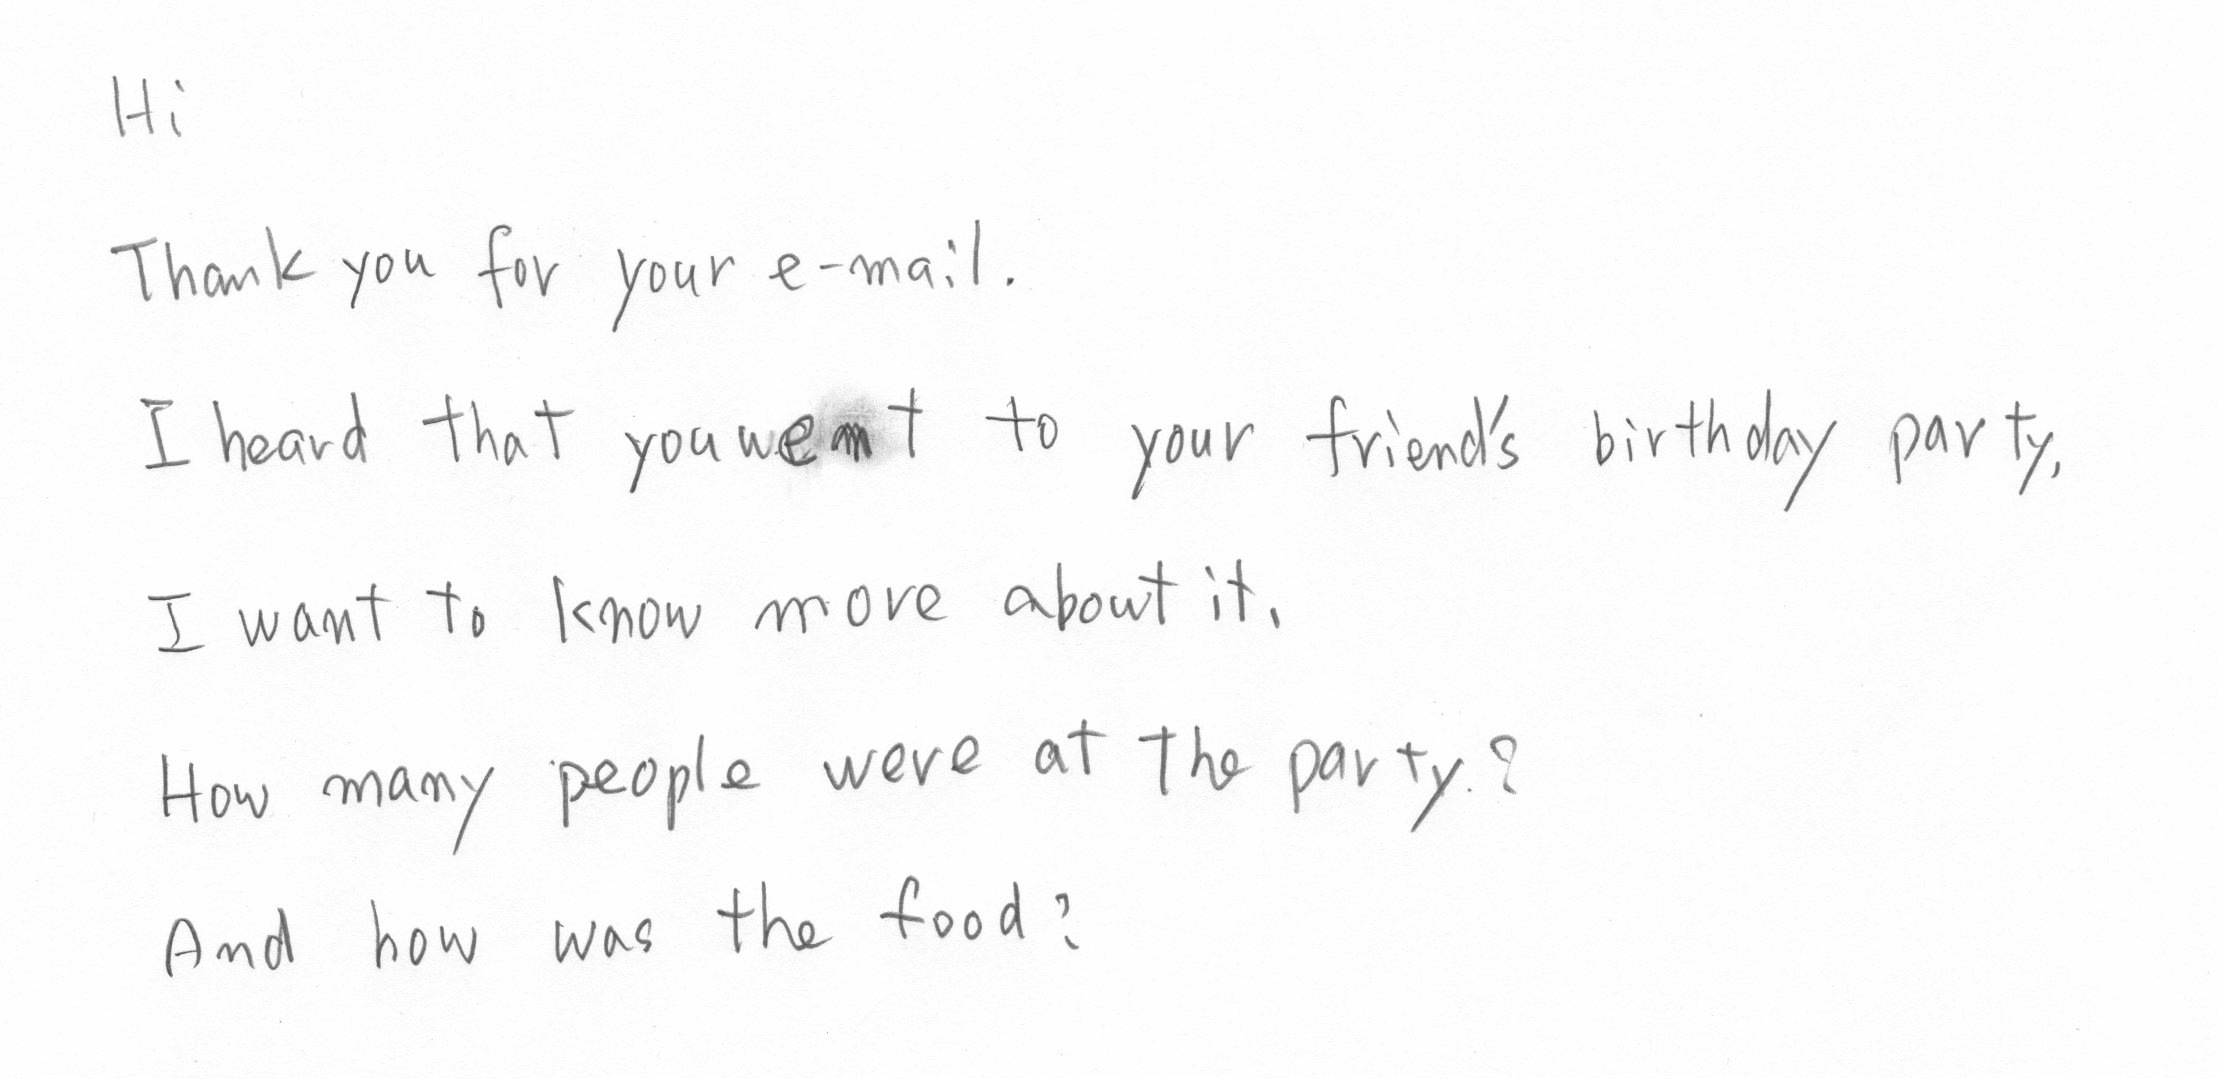

In [13]:
# 表示
fn = 'ocr-sample1.png'
display(Image(filename=fn))

### API key設定


In [8]:
auth_fn = 'vision-api-auth.json'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = auth_fn

### Vision API呼び出し関数

In [9]:
from google.cloud import vision
client = vision.ImageAnnotatorClient()

In [10]:
def call_vision_api(path, language_hint='en'):
    with open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    # 言語ヒントの指定
    image_context = vision.ImageContext(language_hints=[language_hint])
    response = client.text_detection(image=image)
    texts = response.text_annotations
    return texts

### API呼び出し

In [12]:
texts1 = call_vision_api(fn)
text1 = texts1[0].description
print(text1)

ні
Thank you for your e-mail.
I heard that
you weant to
your
I want to know more about it,
friend's birthday party,
How many people were at the party. ?
And how was the food?


In [14]:
texts2 = call_vision_api(fn, 'en-t-i0-handwrit')
text2 = texts2[0].description
print(text2)

ні
Thank you for your e-mail.
I heard that
you weant to
your
I want to know more about it,
friend's birthday party,
How many people were at the party. ?
And how was the food?


### 単語要素の抽出

In [15]:
def parse_json(w):
    text = w.description
    vs = w.bounding_poly.vertices
    xx = []
    yy = []
    for v in vs:
        xx.append(v.x)
        yy.append(v.y)
    xx, yy = np.array(xx), np.array(yy)
    xmin, xmax = xx.min(), xx.max()
    ymin, ymax = yy.min(), yy.max()
    r = pd.DataFrame([[text, xmin, xmax, ymin, ymax]])
    return r

In [20]:
df = pd.DataFrame(None)

for w in texts2[1:]:
    r = parse_json(w)
    df = pd.concat([df, r], axis=0)

df.columns = ['word','xs','xe','ys','ye']
df = df.reset_index(drop=True)

In [21]:
display(df)

,word,xs,xe,ys,ye
0,ні,110,190,72,139
1,Thank,110,318,226,330
2,you,337,434,224,327
3,for,471,561,223,326
4,your,605,737,220,324
5,e,764,803,221,322
6,-,814,843,220,321
7,mail,845,989,217,321
8,.,997,1010,218,319
9,I,138,188,392,461


### 重複行削除

In [27]:
def drop_duplicates(df):
    w = df.copy()
    indexes = []
    w = w.sort_values(['word','xs','ys', 'xe', 'ye'])
    w = w.reset_index(drop=True)
    for i in range(len(w)-1):
        x = w.iloc[i]
        y = w.iloc[i+1]
        cols = ['xs','ys','xe','ye']
        diffs = (np.abs(x[cols].values - y[cols].values) < diff_max).sum()
        if x.word == y.word and  diffs == 4:
            indexes.append(i+1)

    w = w.drop(indexes, axis=0)
    w = w.reset_index(drop=True)
    return w

In [28]:
df = drop_duplicates(df)
display(df)

,word,xs,xe,ys,ye
0,",",1260,1283,558,625
1,",",2037,2056,404,506
2,-,814,843,220,321
3,.,997,1010,218,319
4,.,1438,1484,714,820
5,?,1048,1076,871,936
6,?,1487,1518,713,819
7,And,160,297,902,973
8,How,155,272,740,848
9,I,138,188,392,461


### 検索用項目の計算

In [29]:
df['xm'] = df[['xs', 'xe']].mean(axis=1).astype(int)
df['ym'] = df[['ys', 'ye']].mean(axis=1).astype(int)
df['ys2'] = (df['ym'] - k_rate*(df['ym'] - df['ys'])).astype(int)
df['ye2'] = (df['ym'] + k_rate*(df['ye'] - df['ym'])).astype(int)
df['pos'] = df['xm'] + df['ym']

In [30]:
display(df)

,word,xs,xe,ys,ye,xm,ym,ys2,ye2,pos
0,",",1260,1283,558,625,1271,591,551,631,1862
1,",",2037,2056,404,506,2046,455,393,516,2501
2,-,814,843,220,321,828,270,210,331,1098
3,.,997,1010,218,319,1003,268,208,329,1271
4,.,1438,1484,714,820,1461,767,703,830,2228
5,?,1048,1076,871,936,1062,903,864,942,1965
6,?,1487,1518,713,819,1502,766,702,829,2268
7,And,160,297,902,973,228,937,895,980,1165
8,How,155,272,740,848,213,794,729,858,1007
9,I,138,188,392,461,163,426,385,468,589


### 行テキストの抽出

In [31]:
def get_line(df):
    sentences = []
    indexes = []
    word = ''

    w = df.copy()

    # 左上の単語はposの値で決める
    w = w.sort_values(['pos'])
    s_ind = w['pos'].argsort().index[0]
    s = w.loc[s_ind]
    sentences.append(s.word)
    indexes.append(s_ind)
    word, ys, ye, xm, ym = w.word, s.ys2, s.ye2, s.xm, s.ym

    # 次の単語の探索
    n_list = w.query('ym > @ys and ym < @ye and xm > @xm')

    # 2つめ以降の単語はxwの値で決める
    n_list = n_list.sort_values(['xm'])

    while(len(n_list)):
        s = n_list.iloc[0]
        sentences.append(s.word)
        indexes.append(n_list.index[0])
        word, ys, ye, xm, ym = w.word, s.ys2, s.ye2, s.xm, s.ym

        # 次の単語の探索
        n_list = w.query('ym > @ys and ym < @ye and xm > @xm')

        # 2つめ以降の単語はxwの値で決める
        n_list = n_list.sort_values(['xm'])

    #display(n_list)
    return(sentences, indexes)

In [32]:
sentences = []
w = df.copy()

while(len(w)):
    sentence, indexes = get_line(w)
    sentences += sentence + ['\n']
    w = w.drop(indexes, axis=0)

text = ' '.join(sentences)
text = text.replace(' .', '.')
text = text.replace(' ,', ',')
text = text.replace('\n ', '\n')
print(text)

ні 
Thank you for your e - mail. 
I heard that you weant to your friend's birthday party, 
I want to know more about it, 
How many people were at the party. ? 
And how was the food ? 



### 最終的な関数

In [33]:
def vision_api_to_text(ret):

    # dataframeの生成
    df = pd.DataFrame(None)
    for w in ret[1:]:
        r = parse_json(w)
        df = pd.concat([df, r], axis=0)

    df.columns = ['word','xs','xe','ys','ye']
    df = df.reset_index(drop=True)

    # 重複行の削除
    df = drop_duplicates(df)

    # 重心の計算
    df['xm'] = df[['xs', 'xe']].mean(axis=1).astype(int)
    df['ym'] = df[['ys', 'ye']].mean(axis=1).astype(int)
    df['ys2'] = (df['ym'] - 1.2*(df['ym'] - df['ys'])).astype(int)
    df['ye2'] = (df['ym'] + 1.2*(df['ye'] - df['ym'])).astype(int)

    # 先頭文字算出用
    df['pos'] = df['xm'] + df['ym']

    # 行テキストの抽出
    sentences = []
    w = df.copy()

    while(len(w)):
        sentence, indexes = get_line(w)
        sentences += sentence + ['\n']
        w = w.drop(indexes, axis=0)

    # list -> text
    text = ' '.join(sentences)

    # 整形
    text = text.replace(' .', '.')
    text = text.replace(' ,', ',')
    text = text.replace('\n ', '\n')

    return(text)

### テスト

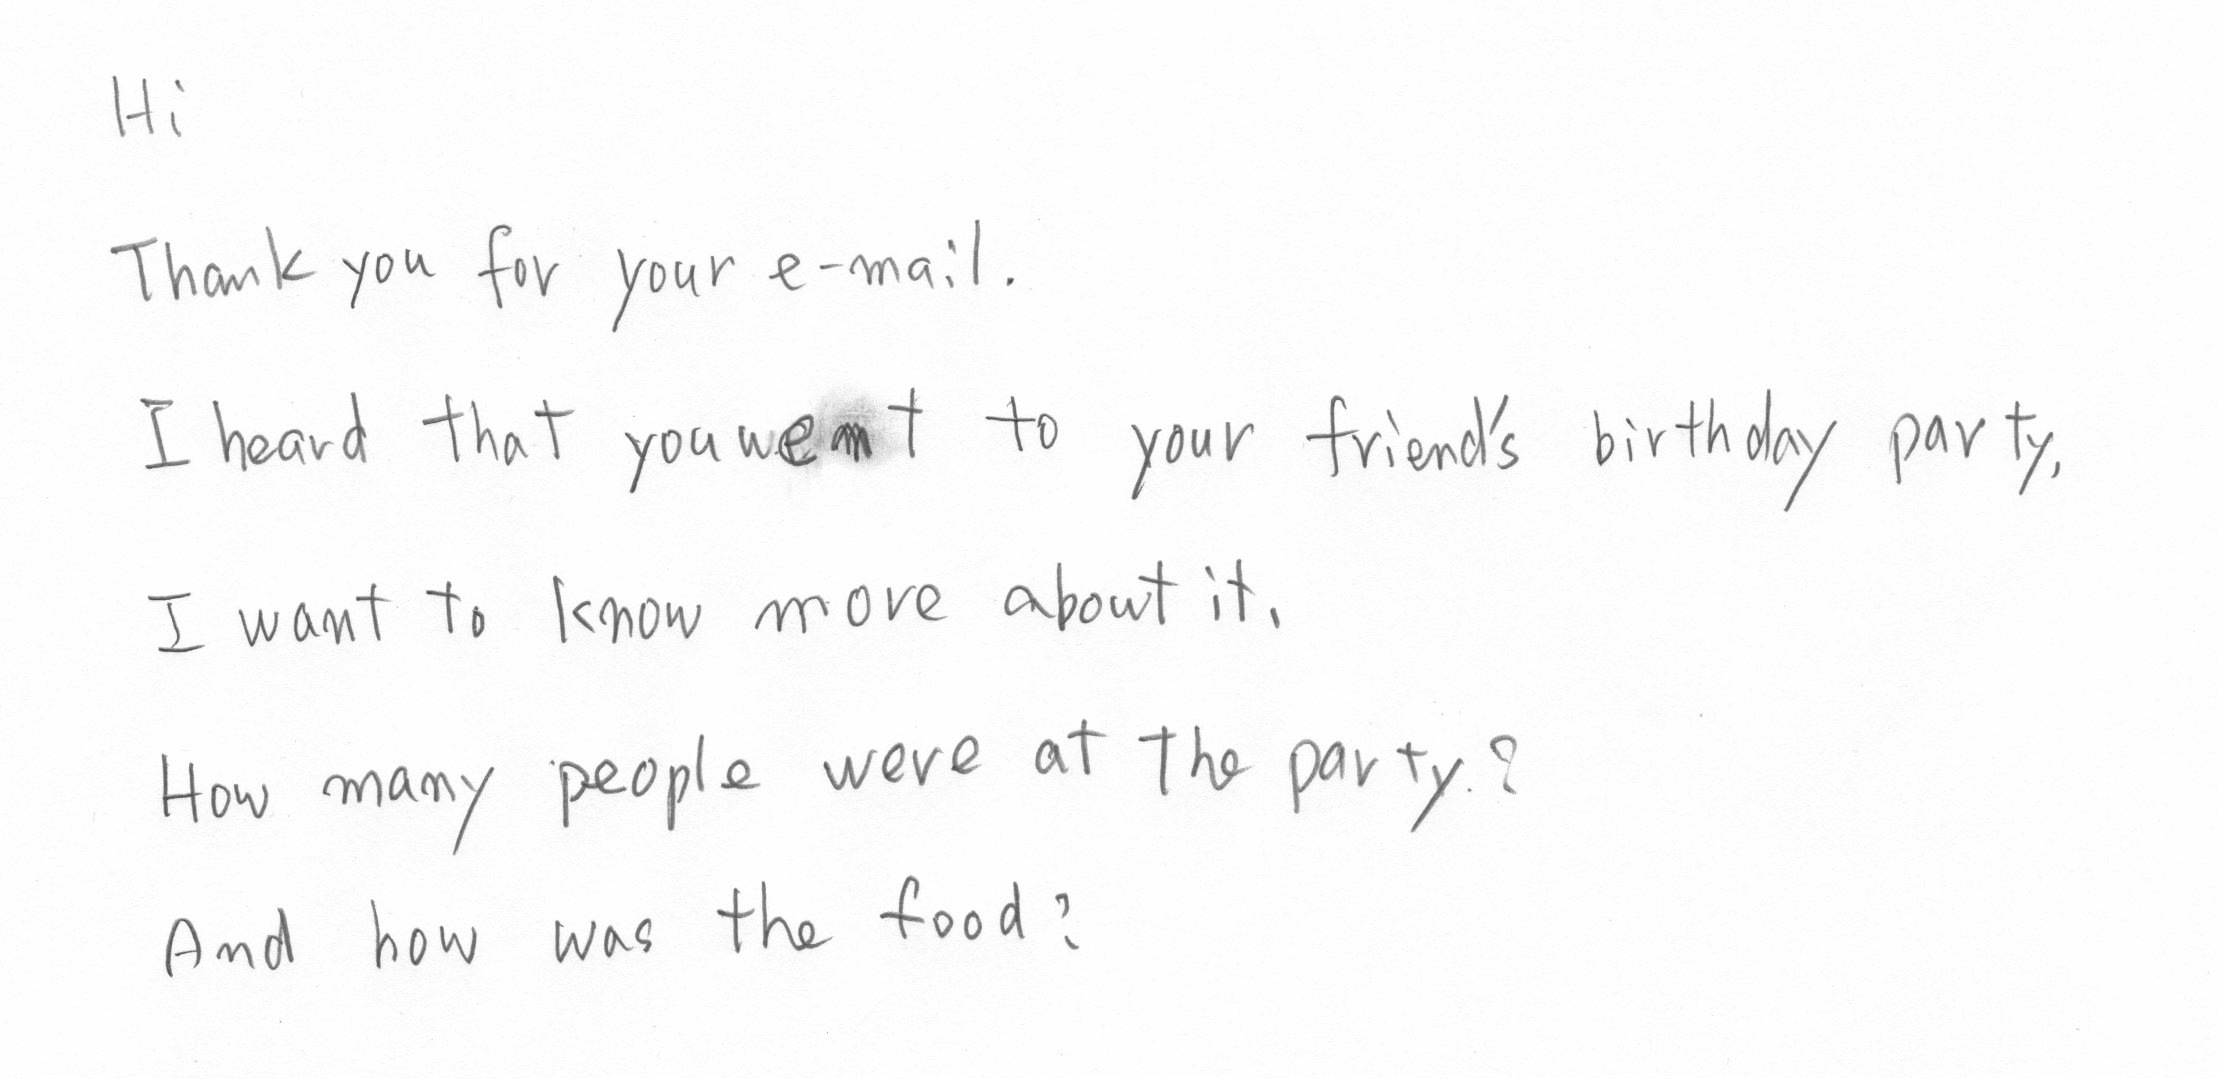

In [34]:
display(Image(filename=fn))

In [35]:
# 動作検証
text3 = vision_api_to_text(texts2)
print(text3)

ні 
Thank you for your e - mail. 
I heard that you weant to your friend's birthday party, 
I want to know more about it, 
How many people were at the party. ? 
And how was the food ? 



In [36]:
# Visio API デフォルトのtext
print(text2)

ні
Thank you for your e-mail.
I heard that
you weant to
your
I want to know more about it,
friend's birthday party,
How many people were at the party. ?
And how was the food?


### CERの計算

In [38]:
!pip install jiwer | tail -n 1
!pip install evaluate | tail -n 1

In [39]:
correct_text = """
Hi
Thank you for your e-mail.
I heard that you want to your friend's birthday party.
I want to know more about it.
How many people were at the party?
And how was the food?
"""

In [40]:
print(correct_text)


Hi
Thank you for your e-mail.
I heard that you want to your friend's birthday party.
I want to know more about it.
How many people were at the party?
And how was the food?



In [41]:
from evaluate import load
cer = load("cer")

In [44]:
cer_org = cer.compute(predictions=[text2], references=[correct_text])
cer_new = cer.compute(predictions=[text3], references=[correct_text])
print(f'org cer: {cer_org:.04f}')
print(f'new cer: {cer_new:.04f}')

org cer: 0.3275
new cer: 0.0877
